# Added for ME249 P1 Task 1.2
**ME249 Project 1 – Task 1.2 概述**
- **日期**: 2025-10-03
- **版本**: v1.0
- **变更日志**:
  - 新增初始化单元与工具函数，统一输出目录 `outputs/1.2/`。
  - 从 Task 1.1 输出加载 45 组沸腾数据，构建线性基线解并计算误差指标。
  - 实现遗传算法（6000 代）含选择/交叉/突变、收敛历史记录与关键可视化，并导出结果文件。


In [2]:
# Added for ME249 P1 Task 1.2
from pathlib import Path
import json
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

OUTPUT_DIR = Path('outputs/1.2')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'figure.dpi': 120,
    'axes.grid': True,
})

def savefig(ax, filename: str):
    """Save matplotlib axis as PNG and PDF inside the Task 1.2 output directory."""
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    for ext in ('png', 'pdf'):
        ax.figure.savefig(OUTPUT_DIR / f"{filename}.{ext}", bbox_inches='tight')
    return ax

def rmse(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    return np.sqrt(np.mean(np.square(y - yhat)))

def mape(y, yhat):
    y = np.asarray(y, dtype=float)
    yhat = np.asarray(yhat, dtype=float)
    return np.mean(np.abs((y - yhat) / y)) * 100.0

def describe_array(name, arr):
    arr = np.asarray(arr, dtype=float)
    print(f"{name} -> count={arr.size}, mean={arr.mean():.4f}, std={arr.std(ddof=1):.4f}, min={arr.min():.4f}, max={arr.max():.4f}")


In [3]:
# Added for ME249 P1 Task 1.2
raw_csv_path = Path('outputs/1.1/boil_45_raw.csv')
if not raw_csv_path.exists():
    raise FileNotFoundError('未找到 Task 1.1 生成的数据文件，请先运行 CodeP1.1F25.ipynb 输出沸腾数据。')

boiling_df = pd.read_csv(raw_csv_path)
print(f'已从 {raw_csv_path} 载入 {len(boiling_df)} 条数据。')
display(boiling_df.head())
display(boiling_df.tail(1))

q_obs = boiling_df['q_pp'].to_numpy(dtype=float)
delta_T = boiling_df['delta_T'].to_numpy(dtype=float)
g_vals = boiling_df['g'].to_numpy(dtype=float)


已从 outputs/1.1/boil_45_raw.csv 载入 45 条数据。


,q_pp,delta_T,g,gamma,P
0,44.2,32.5,0.098,1.79,5.5
1,47.4,33.2,0.098,1.79,5.5
2,49.4,34.2,0.098,1.79,5.5
3,59.2,34.8,0.098,1.79,5.5
4,67.8,36.3,0.098,1.79,5.5


,q_pp,delta_T,g,gamma,P
44,205.0,47.9,19.6,1.79,5.5


In [4]:
# Added for ME249 P1 Task 1.2
log_X = np.column_stack([np.ones_like(delta_T), np.log(delta_T), np.log(g_vals)])
log_y = np.log(q_obs)
coef, *_ = np.linalg.lstsq(log_X, log_y, rcond=None)
ols_log_n1, ols_n2, ols_n3 = coef
ols_n1 = float(np.exp(ols_log_n1))

ols_pred = ols_n1 * (delta_T ** ols_n2) * (g_vals ** ols_n3)
ols_metrics = {
    'RMSE (W/cm²)': rmse(q_obs, ols_pred),
    'MAPE (%)': mape(q_obs, ols_pred),
    'aFerr': float(np.mean(np.abs(ols_pred - q_obs) / q_obs)),
}

print('线性最小二乘基线参数:')
display(pd.DataFrame([
    {
        'n1': ols_n1,
        'n2': ols_n2,
        'n3': ols_n3,
    }
], index=['OLS baseline']))
print()
print('基线误差指标:')
for key, value in ols_metrics.items():
    print(f'{key}: {value:.4f}')


线性最小二乘基线参数:


,n1,n2,n3
OLS baseline,0.00394,2.745118,0.049401



基线误差指标:
RMSE (W/cm²): 19.6047
MAPE (%): 13.8092
aFerr: 0.1381


In [5]:
# Added for ME249 P1 Task 1.2
GA_BOUNDS = np.array([[-5.0, 5.0], [0.0, 5.0], [-2.0, 2.0]])
GA_MUTATION_SCALE = np.array([0.05, 0.03, 0.03])

def initialize_population(size, center, scale=np.array([0.2, 0.1, 0.1])):
    pop = center + np.random.normal(scale=scale, size=(size, center.size))
    lower, upper = GA_BOUNDS[:, 0], GA_BOUNDS[:, 1]
    return np.clip(pop, lower, upper)

def evaluate_population(pop):
    n1 = np.exp(pop[:, 0])
    n2 = pop[:, 1]
    n3 = pop[:, 2]
    preds = n1[:, None] * (delta_T[None, :] ** n2[:, None]) * (g_vals[None, :] ** n3[:, None])
    abs_frac_err = np.abs(preds - q_obs) / q_obs
    mean_abs_frac_err = abs_frac_err.mean(axis=1)
    rmse_values = np.sqrt(((preds - q_obs) ** 2).mean(axis=1))
    return mean_abs_frac_err, rmse_values, preds

def evolve(pop, baseline_genes, elite_frac=0.2, mutation_rate=0.3):
    fitness, rmse_values, preds = evaluate_population(pop)
    order = np.argsort(fitness)
    elite_count = max(2, int(elite_frac * len(pop)))
    elites = pop[order[:elite_count]]

    best_idx = order[0]
    best_state = {
        'genes': pop[best_idx].copy(),
        'error': float(fitness[best_idx]),
        'rmse': float(rmse_values[best_idx]),
        'pred': preds[best_idx].copy(),
    }

    lower, upper = GA_BOUNDS[:, 0], GA_BOUNDS[:, 1]
    weights = 1.0 / (fitness[order[:elite_count]] + 1e-12)
    weights /= weights.sum()

    new_pop = [pop[best_idx].copy()]  # 精英保留
    while len(new_pop) < len(pop):
        parents = elites[np.random.choice(elite_count, size=2, replace=True, p=weights)]
        blend = np.random.rand()
        child = blend * parents[0] + (1.0 - blend) * parents[1]
        if np.random.rand() < mutation_rate:
            child += np.random.normal(scale=GA_MUTATION_SCALE, size=child.shape)
        child = np.clip(child, lower, upper)
        new_pop.append(child)

    new_pop = np.vstack(new_pop[:len(pop)])
    # 引入移民维持多样性
    immigrant = initialize_population(1, baseline_genes, scale=np.array([0.5, 0.3, 0.3]))[0]
    new_pop[-1] = immigrant

    population_mean_error = float(fitness.mean())
    return new_pop, best_state, population_mean_error


In [6]:
# Added for ME249 P1 Task 1.2
generations = 6000
population_size = 60

baseline_genes = np.array([ols_log_n1, ols_n2, ols_n3], dtype=float)
population = initialize_population(population_size, baseline_genes, scale=np.array([0.2, 0.1, 0.1]))

history_rows = []
global_best = None

for gen in range(generations):
    population, best_state, mean_error = evolve(population, baseline_genes)
    best_genes = best_state['genes']
    best_params = {
        'n1': float(np.exp(best_genes[0])),
        'n2': float(best_genes[1]),
        'n3': float(best_genes[2]),
    }

    if global_best is None or best_state['error'] < global_best['error']:
        global_best = {
            'genes': best_genes.copy(),
            'error': best_state['error'],
            'rmse': best_state['rmse'],
            'pred': best_state['pred'].copy(),
            'generation': gen,
        }

    history_rows.append({
        'generation': gen,
        'mean_error': mean_error,
        'min_error': best_state['error'],
        'n1': best_params['n1'],
        'n2': best_params['n2'],
        'n3': best_params['n3'],
    })

history_df = pd.DataFrame(history_rows)

best_genes = global_best['genes']
best_params = {
    'n1': float(np.exp(best_genes[0])),
    'n2': float(best_genes[1]),
    'n3': float(best_genes[2]),
}
best_predictions = global_best['pred']
best_aFerr = float(global_best['error'])
best_rmse = float(global_best['rmse'])
best_mape = mape(q_obs, best_predictions)

print('遗传算法最优参数:')
display(pd.DataFrame([best_params], index=['GA best']))
print(f"最优代数: {global_best['generation']}")
print(f"RMSE = {best_rmse:.4f} W/cm²")
print(f"MAPE = {best_mape:.2f}%")
print(f"aFerr = {best_aFerr:.4f}")

print()
print('收敛历史（最后 5 行）:')
display(history_df.tail())


遗传算法最优参数:


,n1,n2,n3
GA best,0.006738,2.584322,0.022129


最优代数: 2590
RMSE = 21.0439 W/cm²
MAPE = 13.48%
aFerr = 0.1348

收敛历史（最后 5 行）:


,generation,mean_error,min_error,n1,n2,n3
5995,5995,0.258489,0.13484,0.006738,2.584322,0.022129
5996,5996,0.291033,0.13484,0.006738,2.584322,0.022129
5997,5997,0.391381,0.13484,0.006738,2.584322,0.022129
5998,5998,0.166634,0.13484,0.006738,2.584322,0.022129
5999,5999,0.162401,0.13484,0.006738,2.584322,0.022129


In [7]:
# Added for ME249 P1 Task 1.2
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

best_params_path_csv = OUTPUT_DIR / 'task12_best_params.csv'
best_params_path_json = OUTPUT_DIR / 'task12_best_params.json'
metrics_path = OUTPUT_DIR / 'task12_metrics.txt'
history_csv_path = OUTPUT_DIR / 'task12_history.csv'
history_json_path = OUTPUT_DIR / 'task12_history.json'

pd.DataFrame([best_params]).to_csv(best_params_path_csv, index=False)
with open(best_params_path_json, 'w', encoding='utf-8') as f:
    json.dump(best_params, f, indent=2)

best_generation = int(global_best['generation'])
metrics_lines = [
    f"RMSE (W/cm²): {best_rmse:.4f}",
    f"MAPE (%): {best_mape:.2f}",
    f"aFerr: {best_aFerr:.4f}",
    f"Best generation: {best_generation}",
]
with open(metrics_path, 'w', encoding='utf-8') as f:
    for line in metrics_lines:
        print(line, file=f)

history_df.to_csv(history_csv_path, index=False)
history_df.to_json(history_json_path, orient='records', indent=2)

print('已保存参数、指标与历史记录到 outputs/1.2/ 目录。')


已保存参数、指标与历史记录到 outputs/1.2/ 目录。


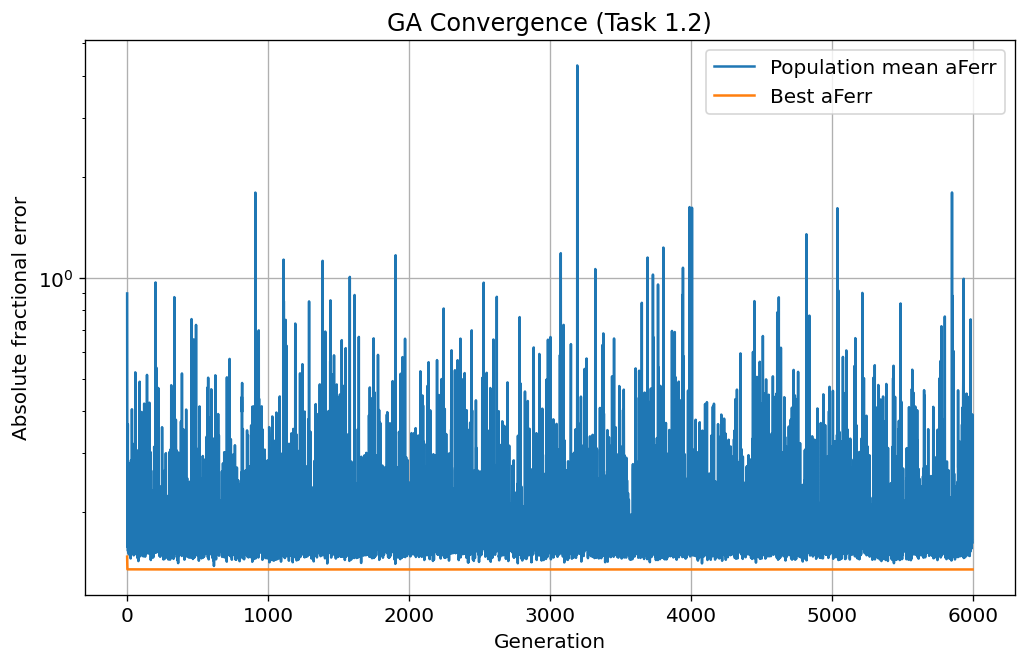

In [8]:
# Added for ME249 P1 Task 1.2
fig, ax = plt.subplots()
ax.plot(history_df['generation'], history_df['mean_error'], label='Population mean aFerr', color='tab:blue')
ax.plot(history_df['generation'], history_df['min_error'], label='Best aFerr', color='tab:orange')
ax.set_xlabel('Generation')
ax.set_ylabel('Absolute fractional error')
ax.set_title('GA Convergence (Task 1.2)')
ax.set_yscale('log')
ax.legend()

savefig(ax, 'task12_convergence')
plt.show()


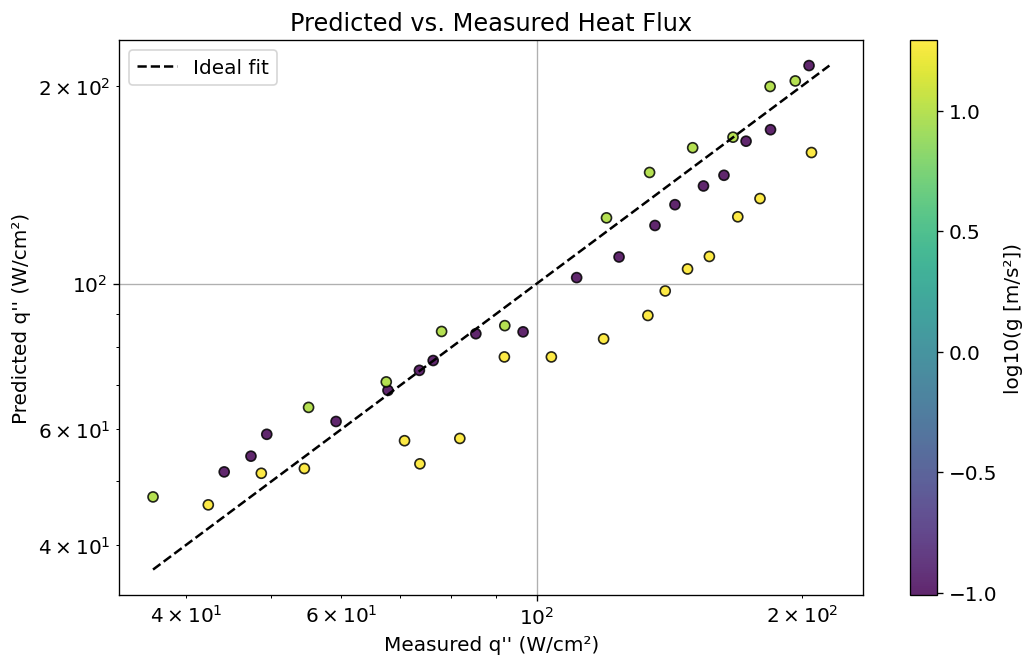

In [9]:
# Added for ME249 P1 Task 1.2
fig, ax = plt.subplots()
scatter = ax.scatter(
    q_obs,
    best_predictions,
    c=np.log10(g_vals),
    cmap='viridis',
    edgecolor='k',
    alpha=0.85,
)
lims = [min(q_obs.min(), best_predictions.min()), max(q_obs.max(), best_predictions.max())]
ax.plot(lims, lims, 'k--', label='Ideal fit')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Measured q'' (W/cm²)")
ax.set_ylabel("Predicted q'' (W/cm²)")
ax.set_title('Predicted vs. Measured Heat Flux')
ax.legend(loc='upper left')
cb = plt.colorbar(scatter, ax=ax)
cb.set_label('log10(g [m/s²])')

savefig(ax, 'task12_parity_pred_vs_exp')
plt.show()
